# Water Potabilty model evaluation

In [1]:
import pandas as pd
import numpy as np

pd.options.display.max_colwidth = 999
pd.options.display.max_rows = 999

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import mutual_info_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
water_data = pd.read_csv('data/water_potability.csv')

### Data cleaning

In [3]:
water_data.columns = water_data.columns.str.lower().str.replace(' ', '_')

In [4]:
ph_mean = water_data['ph'].mean()
ph_mean

7.080794504276819

In [5]:
water_data['ph'] = water_data['ph'].fillna(ph_mean)

In [6]:
sulfate_mean = water_data['sulfate'].mean()
sulfate_mean

333.7757766108134

In [7]:
water_data['sulfate'] = water_data['sulfate'].fillna(sulfate_mean)

In [8]:
water_data = water_data.dropna()

In [9]:
water_data.nunique()

ph                 2650
hardness           3114
solids             3114
chloramines        3114
sulfate            2374
conductivity       3114
organic_carbon     3114
trihalomethanes    3114
turbidity          3114
potability            2
dtype: int64

### Split data

In [10]:
df_full_train, df_test = train_test_split(water_data, test_size=0.2, random_state=1)

df_train, df_val  = train_test_split(df_full_train, test_size=0.25, random_state=1)

len(df_train), len(df_val), len(df_test)

(1868, 623, 623)

In [11]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train['potability'].values
y_val = df_val['potability'].values
y_test = df_test['potability'].values

del df_train['potability']
del df_val['potability']
del df_test['potability']

In [12]:
df_full_train = df_full_train.reset_index(drop=True)
df_full_train['potability'].value_counts(normalize=True)

0    0.604175
1    0.395825
Name: potability, dtype: float64

### Train a model

In [13]:
features = ['trihalomethanes', 'turbidity', 'sulfate', 'hardness', 'ph', 'solids' ]

In [14]:
def train(df, y_train):
    dicts = df[features].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = RandomForestClassifier(
        bootstrap=True,
        criterion='entropy',
        max_features='sqrt',
        n_estimators=100
    )
    model.fit(X_train, y_train)
    
    return dv, model

In [15]:
dv, model = train(df_train, y_train)

In [16]:
def predict(df, dv, model):
    dicts = df[features].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [17]:
y_pred = predict(df_val, dv, model)

### Calculate accuracy

In [18]:
accuracy = accuracy_score(y_val, y_pred >= 0.5)
round(accuracy, 3)

0.673

### Threshold tuning

In [19]:
thresholds = np.linspace(0,1,21)

scores = []

for threshold in thresholds:
    potable_decision = (y_pred >= threshold)
    score = (potable_decision == y_val).mean()
    scores.append((round(threshold, 3), round(score, 3)))

In [20]:
scores

[(0.0, 0.352),
 (0.05, 0.352),
 (0.1, 0.355),
 (0.15, 0.368),
 (0.2, 0.404),
 (0.25, 0.462),
 (0.3, 0.52),
 (0.35, 0.57),
 (0.4, 0.608),
 (0.45, 0.658),
 (0.5, 0.673),
 (0.55, 0.7),
 (0.6, 0.7),
 (0.65, 0.693),
 (0.7, 0.689),
 (0.75, 0.681),
 (0.8, 0.668),
 (0.85, 0.655),
 (0.9, 0.652),
 (0.95, 0.648),
 (1.0, 0.648)]

0.55 threshold gives us the highest accuracy score of 0.692

In [21]:
threshold = 0.55

### Confusion matrix

In [22]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

threshold = 0.5
predict_positive = (y_pred >= threshold)
predict_negative = (y_pred < threshold)

In [23]:
true_positive = (predict_positive & actual_positive).sum()
true_positive

82

In [24]:
true_negative = (predict_negative & actual_negative).sum()
true_negative

337

In [25]:
false_positive = (predict_positive & actual_negative).sum()
false_positive

67

In [26]:
false_negative = (predict_negative & actual_positive).sum()
false_negative

137

In [27]:
confusion_matrix = np.array([
    [true_negative, false_positive],
    [false_negative, true_positive]
])
confusion_matrix

array([[337,  67],
       [137,  82]])

### Precision and Recall

In [28]:
precision = true_positive / (true_positive + false_positive)
precision

0.5503355704697986

In [29]:
recall = true_positive / (true_positive + false_negative)
recall

0.3744292237442922

For 68% of the water samples that are potatable we failed to identify them.

### f1_score

In [31]:
y_preds = pd.Series(y_pred).apply(lambda x: 1 if x >= threshold else 0)

In [32]:
f1 = f1_score(y_val, y_preds)
f1

0.44565217391304346

### ROC values

In [33]:
fpr, tpr, t = roc_curve(y_val, y_pred)

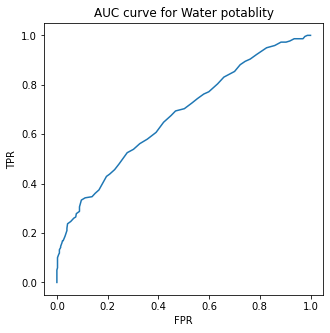

In [34]:
plt.figure(figsize=(5,5))

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.title('AUC curve for Water potablity')
plt.plot(fpr, tpr, label='Model')

In [35]:
roc_auc_score(y_val, y_pred)

0.6725722229757223

### Cross Validation

In [36]:
from sklearn.model_selection import KFold

In [37]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [38]:
train_idx, val_idx = next(kfold.split(df_full_train)) 
len(train_idx), len(val_idx)

(2241, 250)

In [39]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [40]:
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train['potability'].values
    y_val = df_val['potability'].values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append(auc)

In [41]:
scores

[0.6993918031653881,
 0.7033102766798419,
 0.5884831460674158,
 0.6603703201302225,
 0.6462296663909567,
 0.6517940509537148,
 0.7079365079365079,
 0.6605897064630776,
 0.645935960591133,
 0.6224827679416138]